# Predicting Number of Wins in Regular Season

In [2]:
library('tidyverse')
library('MASS')
library('caret')
library('randomForest')
library('sqldf')
library('leaps')


### Load Data

In [73]:
games <- read.csv('~/Downloads/all_teams_final.csv')
head(games)
names(games)

team,season,name,gameId,opposingTeam,home_or_away,gameDate,situation,corsiPercentage,fenwickPercentage,⋯,giveawaysFor,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,playoffGame
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,other,0.0000,0.0000,⋯,0,1,1,0,0,1,0,1,0,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,all,0.6408,0.6310,⋯,8,21,37,1,1,32,17,11,7,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,5on5,0.6429,0.6364,⋯,7,11,25,1,1,18,13,9,5,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,4on5,0.0909,0.1000,⋯,0,8,10,0,0,2,3,0,1,0
NYR,2008,NYR,2008020001,T.B,AWAY,20081004,5on4,0.9524,0.9444,⋯,1,1,1,0,0,11,1,1,1,0
NYR,2008,NYR,2008020003,T.B,HOME,20081005,other,0.6250,0.6667,⋯,0,1,3,0,0,0,0,0,0,0


[1] "team"                "season"              "name"               
 [4] "gameId"              "opposingTeam"        "home_or_away"       
 [7] "gameDate"            "situation"           "corsiPercentage"    
[10] "fenwickPercentage"   "shotsOnGoalFor"      "shotAttemptsFor"    
[13] "goalsFor"            "reboundsFor"         "penalityMinutesFor" 
[16] "faceOffsWonFor"      "hitsFor"             "takeawaysFor"       
[19] "giveawaysFor"        "shotsOnGoalAgainst"  "shotAttemptsAgainst"
[22] "goalsAgainst"        "reboundsAgainst"     "faceOffsWonAgainst" 
[25] "hitsAgainst"         "takeawaysAgainst"    "giveawaysAgainst"   
[28] "playoffGame"

### Remove Special Teams Specifics, Playoff Games, and Lockout Year

In [74]:
games = subset(games, situation == 'all' & playoffGame == 0 & season != 2012)
head(games)

,team,season,name,gameId,opposingTeam,home_or_away,gameDate,situation,corsiPercentage,fenwickPercentage,⋯,giveawaysFor,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,playoffGame
2,NYR,2008,NYR,2008020001,T.B,AWAY,20081004,all,0.6408,0.6310,⋯,8,21,37,1,1,32,17,11,7,0
7,NYR,2008,NYR,2008020003,T.B,HOME,20081005,all,0.6207,0.6190,⋯,11,19,44,1,0,29,31,8,7,0
12,NYR,2008,NYR,2008020010,CHI,HOME,20081010,all,0.4904,0.4643,⋯,6,32,53,2,2,32,31,8,5,0
17,NYR,2008,NYR,2008020019,PHI,AWAY,20081011,all,0.5000,0.4810,⋯,3,28,50,3,2,29,11,5,8,0
22,NYR,2008,NYR,2008020034,N.J,HOME,20081013,all,0.4369,0.4507,⋯,10,27,58,1,4,20,43,9,3,0
27,NYR,2008,NYR,2008020044,BUF,HOME,20081015,all,0.6024,0.5714,⋯,6,19,33,3,3,23,11,10,1,0


### Define column for ROW wins

In [75]:
games$ROW_win = ifelse(games$goalsFor > games$goalsAgainst, 1, 0)
head(games)
names(games)

,team,season,name,gameId,opposingTeam,home_or_away,gameDate,situation,corsiPercentage,fenwickPercentage,⋯,shotsOnGoalAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,playoffGame,ROW_win
2,NYR,2008,NYR,2008020001,T.B,AWAY,20081004,all,0.6408,0.6310,⋯,21,37,1,1,32,17,11,7,0,1
7,NYR,2008,NYR,2008020003,T.B,HOME,20081005,all,0.6207,0.6190,⋯,19,44,1,0,29,31,8,7,0,1
12,NYR,2008,NYR,2008020010,CHI,HOME,20081010,all,0.4904,0.4643,⋯,32,53,2,2,32,31,8,5,0,1
17,NYR,2008,NYR,2008020019,PHI,AWAY,20081011,all,0.5000,0.4810,⋯,28,50,3,2,29,11,5,8,0,1
22,NYR,2008,NYR,2008020034,N.J,HOME,20081013,all,0.4369,0.4507,⋯,27,58,1,4,20,43,9,3,0,1
27,NYR,2008,NYR,2008020044,BUF,HOME,20081015,all,0.6024,0.5714,⋯,19,33,3,3,23,11,10,1,0,0


[1] "team"                "season"              "name"               
 [4] "gameId"              "opposingTeam"        "home_or_away"       
 [7] "gameDate"            "situation"           "corsiPercentage"    
[10] "fenwickPercentage"   "shotsOnGoalFor"      "shotAttemptsFor"    
[13] "goalsFor"            "reboundsFor"         "penalityMinutesFor" 
[16] "faceOffsWonFor"      "hitsFor"             "takeawaysFor"       
[19] "giveawaysFor"        "shotsOnGoalAgainst"  "shotAttemptsAgainst"
[22] "goalsAgainst"        "reboundsAgainst"     "faceOffsWonAgainst" 
[25] "hitsAgainst"         "takeawaysAgainst"    "giveawaysAgainst"   
[28] "playoffGame"         "ROW_win"

### Calculate Season Averages By Team

In [76]:
ROW = sqldf("select team, season, avg(shotsOnGoalFor) as Avg_SOG_For, 
        avg(shotAttemptsFor) as Avg_Shot_Att_For, avg(goalsFor) as Avg_Goals_For,
        avg(reboundsFor) as Avg_Rbds_For, avg(penalityMinutesFor) as Avg_PIM_For,
        avg(faceOffsWonFor) as Avg_FO_Win, avg(faceOffsWonAgainst) as Avg_FO_Lost,
        avg(hitsFor) as Avg_Hits_For, avg(takeawaysFor) as Avg_Tkwy_For,
        avg(giveawaysFor) as Avg_Gvwy_For, avg(shotsOnGoalAgainst) as Avg_SOG_Ag,
        avg(shotAttemptsAgainst) as Avg_Shot_Att_Ag, avg(goalsAgainst) as Avg_GA,
        avg(reboundsAgainst) as Avg_Rbds_Ag, avg(hitsAgainst) as Avg_Hits_Ag,
        avg(takeawaysAgainst) as Avg_Tkwy_Ag, avg(giveawaysAgainst) as Avg_Gvwy_Ag,
        sum(ROW_win) as Num_Wins from games
        --where season = '2018'
        group by team, season
        --order by Num_Wins desc")
head(ROW)
dim(ROW)

team,season,Avg_SOG_For,Avg_Shot_Att_For,Avg_Goals_For,Avg_Rbds_For,Avg_PIM_For,Avg_FO_Win,Avg_FO_Lost,Avg_Hits_For,Avg_Tkwy_For,Avg_Gvwy_For,Avg_SOG_Ag,Avg_Shot_Att_Ag,Avg_GA,Avg_Rbds_Ag,Avg_Hits_Ag,Avg_Tkwy_Ag,Avg_Gvwy_Ag,Num_Wins
ANA,2008,30.25610,52.87805,2.902439,1.792683,15.975610,28.03659,28.24390,21.43902,5.804878,8.182927,30.48780,52.18293,2.865854,2.060976,20.46341,6.121951,7.756098,35
ANA,2009,30.13415,53.18293,2.841463,1.975610,14.475610,26.67073,28.81707,25.00000,5.451220,7.719512,33.37805,58.18293,2.963415,2.475610,21.50000,6.682927,8.060976,34
ANA,2010,28.46341,49.91463,2.865854,1.646341,12.634146,26.90244,29.52439,23.60976,5.439024,7.658537,32.30488,61.48780,2.841463,2.670732,21.91463,6.439024,9.048780,43
ANA,2011,27.95122,53.74390,2.451220,1.682927,10.475610,26.24390,29.12195,22.63415,5.402439,8.121951,28.86585,55.96341,2.731707,2.463415,22.57317,6.378049,8.256098,31
ANA,2013,31.32927,57.40244,3.207317,2.292683,10.024390,31.59756,32.62195,24.68293,5.451220,8.170732,28.70732,57.04878,2.475610,2.121951,24.84146,5.304878,8.670732,51
ANA,2014,29.97561,57.54878,2.780488,1.853659,9.658537,32.34146,30.28049,28.06098,5.841463,9.085366,28.86585,55.14634,2.695122,1.890244,26.67073,6.280488,9.621951,43


[1] 302  20

In [77]:
cor(ROW[,-c(1,2)])

,Avg_SOG_For,Avg_Shot_Att_For,Avg_Goals_For,Avg_Rbds_For,Avg_PIM_For,Avg_FO_Win,Avg_FO_Lost,Avg_Hits_For,Avg_Tkwy_For,Avg_Gvwy_For,Avg_SOG_Ag,Avg_Shot_Att_Ag,Avg_GA,Avg_Rbds_Ag,Avg_Hits_Ag,Avg_Tkwy_Ag,Avg_Gvwy_Ag,Num_Wins
Avg_SOG_For,1.00000000,0.88767548,0.577933053,0.45286917,-0.19203501,0.3903669957,-0.070697700,-0.02792015,0.24027008,0.155358065,-0.14866844,-0.24392165,-0.10586480,-0.024057734,0.249834282,0.2333010168,0.20557647,0.44821906
Avg_Shot_Att_For,0.88767548,1.00000000,0.476536124,0.50599103,-0.20508258,0.4722883291,-0.039637199,0.07386551,0.25556945,0.263969600,-0.20864122,-0.17674940,-0.13886277,0.024403677,0.346057242,0.2537158864,0.33295803,0.40324499
Avg_Goals_For,0.57793305,0.47653612,1.000000000,0.16705436,-0.04053884,0.2089074520,0.009519019,-0.14622800,0.22425038,0.204447986,-0.03555183,-0.08030526,-0.07041484,0.030206244,0.058574894,0.2482395438,0.19188410,0.73042493
Avg_Rbds_For,0.45286917,0.50599103,0.167054364,1.00000000,-0.20304470,0.3024886447,0.026544396,0.09565062,0.24095604,0.205792232,-0.03594688,0.10473874,0.06343974,0.409537335,0.116626264,0.1331952701,0.22538020,0.11305960
Avg_PIM_For,-0.19203501,-0.20508258,-0.040538842,-0.20304470,1.00000000,-0.2479624777,-0.208252490,0.12011092,-0.16463880,-0.206946788,-0.04273617,-0.07944417,-0.01702001,-0.159732240,-0.122346160,-0.0906516080,-0.18266515,-0.11237459
Avg_FO_Win,0.39036700,0.47228833,0.208907452,0.30248864,-0.24796248,1.0000000000,-0.056068142,0.05810322,0.01476033,0.042261983,-0.03438174,-0.03179687,-0.08661999,-0.003574594,0.218783819,-0.0004673553,0.09890709,0.22120481
Avg_FO_Lost,-0.07069770,-0.03963720,0.009519019,0.02654440,-0.20825249,-0.0560681416,1.000000000,0.13605025,0.02920731,0.140322237,0.36083542,0.44818672,0.23755522,0.264578229,-0.045834295,-0.0120256079,0.13440297,-0.12153394
Avg_Hits_For,-0.02792015,0.07386551,-0.146227999,0.09565062,0.12011092,0.0581032194,0.136050247,1.00000000,-0.16953213,-0.039346711,0.02639679,0.11100891,-0.05012016,0.078032243,0.507919743,-0.1390954881,0.04478141,-0.10167387
Avg_Tkwy_For,0.24027008,0.25556945,0.224250383,0.24095604,-0.16463880,0.0147603262,0.029207310,-0.16953213,1.00000000,0.361047485,0.09329313,0.14353043,0.24230679,0.138102883,-0.074998566,0.7790221704,0.32081981,0.02128798
Avg_Gvwy_For,0.15535806,0.26396960,0.204447986,0.20579223,-0.20694679,0.0422619829,0.140322237,-0.03934671,0.36104748,1.000000000,0.16415321,0.25797731,0.24110104,0.207360295,-0.004778589,0.4109419381,0.86770131,0.03761832


### Split Data Into Training and Testing

In [78]:
set.seed(12)
shuff = ROW[sample(length(ROW[,1])),]
trainSize = floor(0.8*length(ROW[,1])) 
n = trainSize
n
#ROW_train = subset(ROW, season %in% c(2010:2017))
#ROW_test = subset(ROW, season == 2018)
ROW_train = shuff[1:trainSize,]
ROW_test = shuff[trainSize:length(ROW[,1]),]
head(ROW_train)
head(ROW_test)

[1] 241

,team,season,Avg_SOG_For,Avg_Shot_Att_For,Avg_Goals_For,Avg_Rbds_For,Avg_PIM_For,Avg_FO_Win,Avg_FO_Lost,Avg_Hits_For,Avg_Tkwy_For,Avg_Gvwy_For,Avg_SOG_Ag,Avg_Shot_Att_Ag,Avg_GA,Avg_Rbds_Ag,Avg_Hits_Ag,Avg_Tkwy_Ag,Avg_Gvwy_Ag,Num_Wins
21,ATL,2008,28.12195,50.26829,3.048780,2.121951,13.560976,30.32927,28.97561,16.82927,9.012195,8.170732,32.71951,57.64634,3.402439,1.975610,14.70732,7.804878,7.146341,28
247,STL,2011,30.63415,57.57317,2.512195,2.292683,11.658537,28.48780,28.01220,23.76829,6.097561,4.634146,26.70732,51.12195,1.890244,1.646341,21.21951,5.414634,6.487805,45
283,VAN,2018,29.56098,55.03659,2.646341,1.743902,7.500000,29.20732,29.81707,21.85366,6.500000,7.414634,31.47561,58.50000,3.000000,2.134146,21.09756,6.682927,8.012195,29
81,CHI,2016,30.59756,56.50000,2.926829,2.036585,6.414634,27.26829,30.17073,14.36585,7.329268,9.463415,31.40244,56.74390,2.585366,2.670732,26.30488,7.512195,8.646341,46
51,CAR,2016,30.40244,58.29268,2.585366,2.719512,5.487805,29.64634,26.21951,19.64634,10.268293,9.585366,28.29268,53.19512,2.804878,2.463415,22.92683,9.902439,8.439024,33
11,ARI,2008,28.01235,51.32099,2.469136,1.716049,11.901235,25.50617,31.24691,22.13580,4.703704,4.962963,31.54321,59.35802,3.061728,2.000000,21.86420,5.493827,6.148148,32


,team,season,Avg_SOG_For,Avg_Shot_Att_For,Avg_Goals_For,Avg_Rbds_For,Avg_PIM_For,Avg_FO_Win,Avg_FO_Lost,Avg_Hits_For,Avg_Tkwy_For,Avg_Gvwy_For,Avg_SOG_Ag,Avg_Shot_Att_Ag,Avg_GA,Avg_Rbds_Ag,Avg_Hits_Ag,Avg_Tkwy_Ag,Avg_Gvwy_Ag,Num_Wins
132,FLA,2017,34.42683,60.25610,2.987805,2.609756,9.597561,32.40244,31.45122,20.15854,9.097561,13.121951,34.62195,60.50000,2.963415,2.487805,18.29268,8.329268,10.731707,41
109,DET,2014,29.62195,54.86585,2.817073,1.829268,8.439024,31.47561,29.68293,19.13415,5.060976,7.329268,28.31707,49.34146,2.573171,1.548780,23.53659,5.560976,6.865854,39
46,CAR,2010,30.69512,60.18293,2.817073,2.219512,9.402439,26.73171,33.18293,25.95122,8.597561,7.243902,33.23171,61.98780,2.853659,2.597561,20.68293,7.890244,7.682927,35
124,FLA,2008,29.41463,53.64634,2.817073,2.146341,10.292683,27.93902,30.39024,19.04878,6.024390,7.341463,34.68293,60.82927,2.719512,2.524390,20.95122,5.841463,6.975610,38
195,NYR,2009,29.57317,55.18293,2.670732,1.987805,12.402439,27.25610,28.17073,28.41463,7.219512,5.524390,29.87805,56.32927,2.609756,2.000000,28.35366,6.512195,6.487805,35
258,T.B,2013,29.84146,54.60976,2.829268,1.951220,9.268293,29.19512,30.09756,20.02439,6.243902,7.804878,29.25610,55.20732,2.548780,1.841463,20.79268,7.158537,6.560976,38


### Create Model Via Backwards Selection w/ $\alpha_{crit} = 0.20$

In [79]:
lmod = lm(Num_Wins ~. - team - season, data = ROW_train )
summary(lmod)


Call:
lm(formula = Num_Wins ~ . - team - season, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0836 -1.7271  0.0938  1.7004  6.1340 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.554120   6.455971   6.591 3.11e-10 ***
Avg_SOG_For        0.013327   0.275471   0.048 0.961457    
Avg_Shot_Att_For  -0.098520   0.138534  -0.711 0.477730    
Avg_Goals_For     16.604359   0.753757  22.029  < 2e-16 ***
Avg_Rbds_For      -0.160879   0.752123  -0.214 0.830821    
Avg_PIM_For       -0.383647   0.097482  -3.936 0.000111 ***
Avg_FO_Win         0.115516   0.133853   0.863 0.389063    
Avg_FO_Lost       -0.016627   0.144570  -0.115 0.908539    
Avg_Hits_For       0.008319   0.063968   0.130 0.896651    
Avg_Tkwy_For      -0.143803   0.234844  -0.612 0.540941    
Avg_Gvwy_For      -0.188721   0.192340  -0.981 0.327565    
Avg_SOG_Ag        -0.413757   0.207195  -1.997 0.047047 *  
Avg_Shot_Att_Ag    0.027904   0.117651   0.

In [80]:
lmod2 = update(lmod, . ~ . - Avg_SOG_For)
summary(lmod2)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_Rbds_For + 
    Avg_PIM_For + Avg_FO_Win + Avg_FO_Lost + Avg_Hits_For + Avg_Tkwy_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_Shot_Att_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0902 -1.7316  0.1008  1.6990  6.1283 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.647812   6.144929   6.940 4.17e-11 ***
Avg_Shot_Att_For  -0.092940   0.076579  -1.214  0.22616    
Avg_Goals_For     16.618544   0.692848  23.986  < 2e-16 ***
Avg_Rbds_For      -0.151763   0.726514  -0.209  0.83472    
Avg_PIM_For       -0.384355   0.096161  -3.997 8.71e-05 ***
Avg_FO_Win         0.114127   0.130447   0.875  0.38257    
Avg_FO_Lost       -0.016284   0.144074  -0.113  0.91011    
Avg_Hits_For       0.008266   0.063817   0.130  0.89706    
Avg_Tkwy_For      -0.143475   0.234223  -0.613  0.54079 

In [81]:
lmod3 = update(lmod2, . ~ . - Avg_FO_Lost)
summary(lmod3)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_Rbds_For + 
    Avg_PIM_For + Avg_FO_Win + Avg_Hits_For + Avg_Tkwy_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_Shot_Att_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0898 -1.7485  0.0844  1.7054  6.1301 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.314025   5.376895   7.870 1.49e-13 ***
Avg_Shot_Att_For  -0.093669   0.076140  -1.230  0.21990    
Avg_Goals_For     16.609993   0.687193  24.171  < 2e-16 ***
Avg_Rbds_For      -0.146570   0.723468  -0.203  0.83964    
Avg_PIM_For       -0.382037   0.093742  -4.075 6.37e-05 ***
Avg_FO_Win         0.115492   0.129602   0.891  0.37381    
Avg_Hits_For       0.007106   0.062848   0.113  0.91008    
Avg_Tkwy_For      -0.143902   0.233678  -0.616  0.53864    
Avg_Gvwy_For      -0.190220   0.190673  -0.998  0.31953    
Avg_SOG_Ag

In [82]:
lmod4 = update(lmod3, . ~ . - Avg_Hits_For)
summary(lmod4)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_Rbds_For + 
    Avg_PIM_For + Avg_FO_Win + Avg_Tkwy_For + Avg_Gvwy_For + 
    Avg_SOG_Ag + Avg_Shot_Att_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Tkwy_Ag + Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0945 -1.7351  0.0684  1.7199  6.1313 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.31651    5.36509   7.887 1.31e-13 ***
Avg_Shot_Att_For  -0.09378    0.07597  -1.235   0.2183    
Avg_Goals_For     16.59775    0.67713  24.512  < 2e-16 ***
Avg_Rbds_For      -0.13989    0.71947  -0.194   0.8460    
Avg_PIM_For       -0.37957    0.09098  -4.172 4.30e-05 ***
Avg_FO_Win         0.11570    0.12931   0.895   0.3719    
Avg_Tkwy_For      -0.14617    0.23231  -0.629   0.5299    
Avg_Gvwy_For      -0.19156    0.18989  -1.009   0.3141    
Avg_SOG_Ag        -0.40892    0.18214  -2.245   0.0257 *  
Avg_Shot_Att_Ag    0.02344    0.101

In [83]:
lmod5 = update(lmod4, . ~ . -Avg_Rbds_For)
summary(lmod5)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_Shot_Att_Ag + 
    Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, 
    data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0943 -1.7663  0.0754  1.7340  6.1456 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.41349    5.33052   7.957 8.35e-14 ***
Avg_Shot_Att_For  -0.10002    0.06871  -1.456 0.146850    
Avg_Goals_For     16.60920    0.67313  24.675  < 2e-16 ***
Avg_PIM_For       -0.37893    0.09072  -4.177 4.22e-05 ***
Avg_FO_Win         0.11350    0.12854   0.883 0.378161    
Avg_Tkwy_For      -0.15746    0.22445  -0.702 0.483669    
Avg_Gvwy_For      -0.18906    0.18905  -1.000 0.318337    
Avg_SOG_Ag        -0.39714    0.17140  -2.317 0.021390 *  
Avg_Shot_Att_Ag    0.01962    0.09956   0.197 0.843951    
Avg_GA           -13.44120    0.78760 -17.066  < 2

In [84]:
lmod6 = update(lmod5, . ~ . - Avg_Shot_Att_Ag)
summary(lmod6)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + 
    Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0410 -1.7916  0.0724  1.7573  6.0745 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.71054    5.10217   8.371 5.79e-15 ***
Avg_Shot_Att_For  -0.10190    0.06790  -1.501 0.134788    
Avg_Goals_For     16.60627    0.67155  24.728  < 2e-16 ***
Avg_PIM_For       -0.37856    0.09051  -4.182 4.11e-05 ***
Avg_FO_Win         0.11418    0.12822   0.890 0.374159    
Avg_Tkwy_For      -0.15346    0.22305  -0.688 0.492151    
Avg_Gvwy_For      -0.19108    0.18837  -1.014 0.311471    
Avg_SOG_Ag        -0.37383    0.12378  -3.020 0.002815 ** 
Avg_GA           -13.42203    0.77992 -17.210  < 2e-16 ***
Avg_Rbds_Ag        2.43146    0.65478   3.713 0.000257 ***
Avg_Hits_Ag   

In [85]:
lmod7 = update(lmod6, . ~ . - Avg_Tkwy_Ag)
summary(lmod7)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + 
    Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0340 -1.8096  0.0737  1.8280  6.0782 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.64877    5.08608   8.385 5.18e-15 ***
Avg_Shot_Att_For  -0.10074    0.06761  -1.490 0.137581    
Avg_Goals_For     16.62345    0.66683  24.929  < 2e-16 ***
Avg_PIM_For       -0.37733    0.09020  -4.183 4.09e-05 ***
Avg_FO_Win         0.11220    0.12773   0.878 0.380626    
Avg_Tkwy_For      -0.11242    0.15514  -0.725 0.469409    
Avg_Gvwy_For      -0.18818    0.18765  -1.003 0.316999    
Avg_SOG_Ag        -0.37466    0.12348  -3.034 0.002691 ** 
Avg_GA           -13.37613    0.75757 -17.657  < 2e-16 ***
Avg_Rbds_Ag        2.43474    0.65332   3.727 0.000244 ***
Avg_Hits_Ag       -0.13973  

In [86]:
lmod8 = update(lmod7, . ~ . - Avg_Tkwy_For)
summary(lmod8)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9109 -1.7977  0.0947  1.7767  6.1654 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       42.37980    5.06728   8.363 5.88e-15 ***
Avg_Shot_Att_For  -0.10995    0.06634  -1.657 0.098797 .  
Avg_Goals_For     16.56221    0.66077  25.065  < 2e-16 ***
Avg_PIM_For       -0.37137    0.08973  -4.139 4.90e-05 ***
Avg_FO_Win         0.12059    0.12707   0.949 0.343623    
Avg_Gvwy_For      -0.20447    0.18610  -1.099 0.273057    
Avg_SOG_Ag        -0.36982    0.12318  -3.002 0.002974 ** 
Avg_GA           -13.47055    0.74551 -18.069  < 2e-16 ***
Avg_Rbds_Ag        2.42300    0.65245   3.714 0.000256 ***
Avg_Hits_Ag       -0.13272    0.06530  -2.033 0.043252 *  
Avg_Gvwy_Ag        0.30016    0.22118   1.3

In [87]:
lmod9 = update(lmod8, . ~ . - Avg_FO_Win)
summary(lmod9)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Gvwy_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0387 -1.8952  0.0622  1.6777  6.2041 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       44.17063    4.70178   9.394  < 2e-16 ***
Avg_Shot_Att_For  -0.08316    0.06002  -1.386 0.167211    
Avg_Goals_For     16.54758    0.66045  25.055  < 2e-16 ***
Avg_PIM_For       -0.38383    0.08875  -4.325 2.27e-05 ***
Avg_Gvwy_For      -0.22041    0.18530  -1.189 0.235473    
Avg_SOG_Ag        -0.35250    0.12179  -2.894 0.004164 ** 
Avg_GA           -13.48272    0.74524 -18.092  < 2e-16 ***
Avg_Rbds_Ag        2.41525    0.65226   3.703 0.000267 ***
Avg_Hits_Ag       -0.12956    0.06520  -1.987 0.048084 *  
Avg_Gvwy_Ag        0.30249    0.22112   1.368 0.172657    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’

In [88]:
lmod10 = update(lmod9, . ~ . - Avg_Gvwy_For)
summary(lmod10)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, 
    data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1778 -1.9375  0.0745  1.7437  6.0765 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       43.90906    4.70083   9.341  < 2e-16 ***
Avg_Shot_Att_For  -0.07709    0.05986  -1.288 0.199050    
Avg_Goals_For     16.47139    0.65792  25.035  < 2e-16 ***
Avg_PIM_For       -0.37222    0.08829  -4.216 3.57e-05 ***
Avg_SOG_Ag        -0.33523    0.12103  -2.770 0.006062 ** 
Avg_GA           -13.59720    0.73966 -18.383  < 2e-16 ***
Avg_Rbds_Ag        2.26658    0.64074   3.537 0.000488 ***
Avg_Hits_Ag       -0.12458    0.06512  -1.913 0.056985 .  
Avg_Gvwy_Ag        0.08222    0.12095   0.680 0.497346    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.776 on 232 degrees of freedom
Multi

In [89]:
lmod11 = update(lmod10, . ~ . - Avg_Gvwy_Ag)
summary(lmod11)


Call:
lm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0907 -1.7765  0.0679  1.7512  6.0033 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       43.47830    4.65254   9.345  < 2e-16 ***
Avg_Shot_Att_For  -0.06481    0.05700  -1.137 0.256684    
Avg_Goals_For     16.50438    0.65537  25.183  < 2e-16 ***
Avg_PIM_For       -0.38162    0.08710  -4.381 1.78e-05 ***
Avg_SOG_Ag        -0.32554    0.12005  -2.712 0.007191 ** 
Avg_GA           -13.52726    0.73162 -18.489  < 2e-16 ***
Avg_Rbds_Ag        2.25286    0.63968   3.522 0.000516 ***
Avg_Hits_Ag       -0.12517    0.06504  -1.924 0.055524 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.773 on 233 degrees of freedom
Multiple R-squared:  0.8637,	Adjusted R-squared:  0.8596 
F-statistic: 210.9 on 7 a

In [90]:
lmod12 = update(lmod11, . ~ . - Avg_Shot_Att_For)
summary(lmod12)


Call:
lm(formula = Num_Wins ~ Avg_Goals_For + Avg_PIM_For + Avg_SOG_Ag + 
    Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag, data = ROW_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1053 -1.7756  0.0441  1.7147  6.3175 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    40.47281    3.83116  10.564  < 2e-16 ***
Avg_Goals_For  16.14181    0.57293  28.174  < 2e-16 ***
Avg_PIM_For    -0.36440    0.08583  -4.246 3.14e-05 ***
Avg_SOG_Ag     -0.29119    0.11626  -2.505 0.012936 *  
Avg_GA        -13.59558    0.72961 -18.634  < 2e-16 ***
Avg_Rbds_Ag     2.18921    0.63763   3.433 0.000705 ***
Avg_Hits_Ag    -0.14853    0.06175  -2.405 0.016930 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.775 on 234 degrees of freedom
Multiple R-squared:  0.8629,	Adjusted R-squared:  0.8594 
F-statistic: 245.5 on 6 and 234 DF,  p-value: < 2.2e-16


$$ Y = 40.47 + 16.14X_{GF} - 0.36X_{PIM} - 0.29X_{SOG.Ag} - 13.60X_{GA} + 2.19X_{RB.Ag} - 0.15X_{Hits.Ag} $$

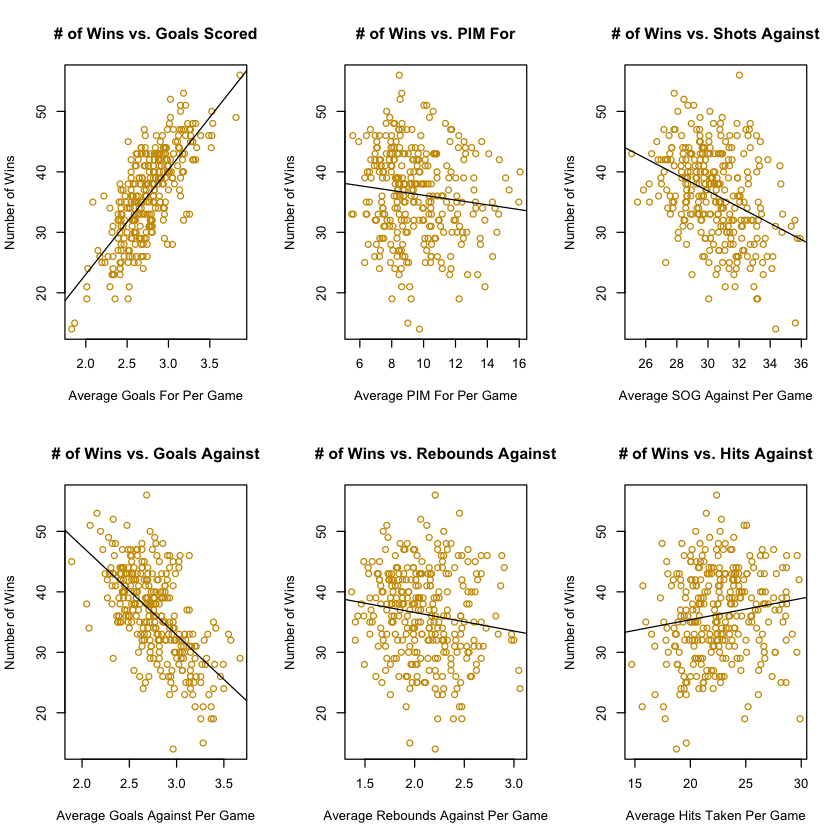

In [91]:
par(mfrow=c(2,3))
#par(bg = '#CCCCCC')
with(ROW, plot(Avg_Goals_For, Num_Wins, ylab = 'Number of Wins', 
              xlab = 'Average Goals For Per Game',
              main = '# of Wins vs. Goals Scored', col = '#CC9900'))
abline(lm(Num_Wins~ Avg_Goals_For, data = ROW))
with(ROW, plot(Avg_PIM_For, Num_Wins, ylab = 'Number of Wins',
              xlab = 'Average PIM For Per Game',
              main = '# of Wins vs. PIM For', col = '#CC9900'))
abline(lm(Num_Wins~ Avg_PIM_For, data = ROW))
with(ROW, plot(Avg_SOG_Ag, Num_Wins, ylab = 'Number of Wins',
              xlab = 'Average SOG Against Per Game',
              main = '# of Wins vs. Shots Against', col = '#CC9900'))
abline(lm(Num_Wins~ Avg_SOG_Ag, data = ROW))
with(ROW, plot(Avg_GA, Num_Wins, ylab = 'Number of Wins',
              xlab = 'Average Goals Against Per Game',
              main = '# of Wins vs. Goals Against', col = '#CC9900'))
abline(lm(Num_Wins~ Avg_GA, data = ROW))
with(ROW, plot(Avg_Rbds_Ag, Num_Wins, ylab = 'Number of Wins',
              xlab = 'Average Rebounds Against Per Game',
              main = '# of Wins vs. Rebounds Against', col = '#CC9900'))
abline(lm(Num_Wins~ Avg_Rbds_Ag, data = ROW))
with(ROW, plot(Avg_Hits_Ag, Num_Wins, ylab = 'Number of Wins',
              xlab = 'Average Hits Taken Per Game',
              main = '# of Wins vs. Hits Against', col = '#CC9900'))
abline(lm(Num_Wins~ Avg_Hits_Ag, data = ROW))

### Review Diagnostics of Final Model Via Backwards Selection

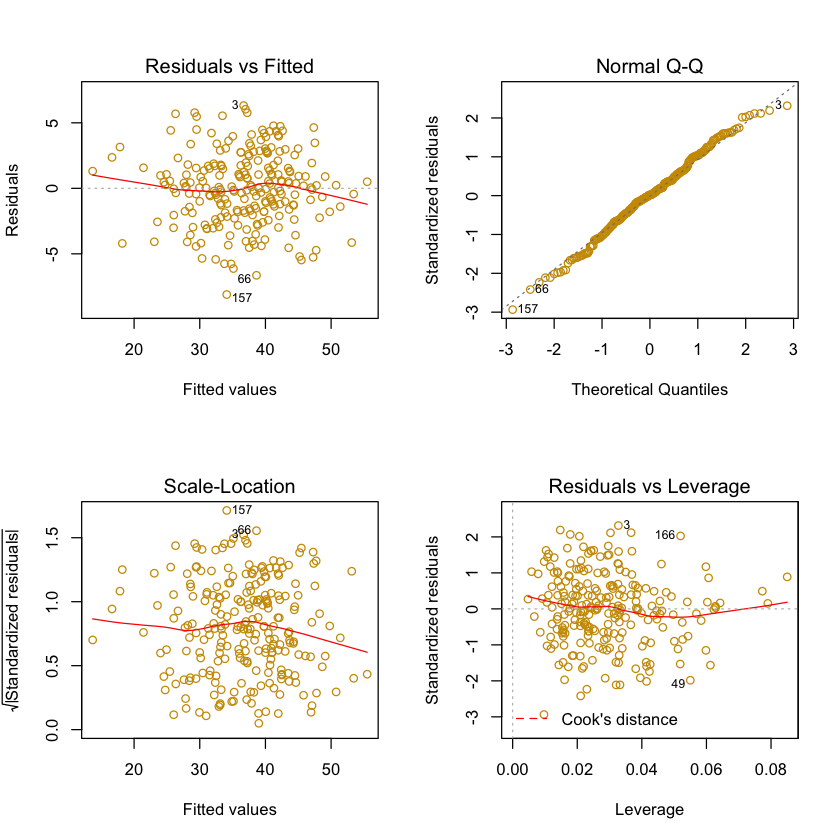

In [92]:
par(mfrow=c(2,2))
plot(lmod12, col = '#CC9900')

### Check Model on Testing Dataset and  MSE of Full and Reduced Model

#### Full Model Predictions/MSE

In [93]:
preds_full = (predict(lmod, ROW_test, type='response'))
checks_full = cbind(preds_full, ROW_test$Num_Wins)
head(checks_full)
MSE_full = mean((checks_full[,1]-checks_full[,2])^2)
MSE_full

,preds_full,
132,36.80268,41
109,39.74942,39
46,35.70062,35
124,37.09866,38
195,34.78837,35
258,40.35513,38


[1] 5.354364

#### Reduced Model Predictions/MSE

In [100]:
Predicted_Wins = predict(lmod12, ROW_test, type='response')
checks_red = data.frame('Team' = ROW_test$team, 'Season' = ROW_test$season, 
                        'Number of Wins' =ROW_test$Num_Wins, 'Predicted Wins' = round(Predicted_Wins))
names(checks_red)  
head(checks_red)
MSE_red = mean((checks_red[,3]-checks_red[,4])^2)
MSE_red

[1] "Team"           "Season"         "Number.of.Wins" "Predicted.Wins"

,Team,Season,Number.of.Wins,Predicted.Wins
132,FLA,2017,41,38
109,DET,2014,39,40
46,CAR,2010,35,37
124,FLA,2008,38,38
195,NYR,2009,35,35
258,T.B,2013,38,41


[1] 5.467742

The MSE of the reduced model is actually slightly lower than that of the full model.  This leads us to believe that the full model is certainly overfit and the reduced model is sufficient, but let's double check with a partial F-Test.

#### Partial F-Test Between Reduced and Full Model

In [72]:
anova(lmod12, lmod)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
204,1545.940,NA,NA,NA,NA
193,1446.678,11,99.26265,1.203868,0.2866249


With $p=0.94562 >> 0.05$, the reduced model is certainly sufficient.

## Create Model w/ Regsubsets

[1] 6

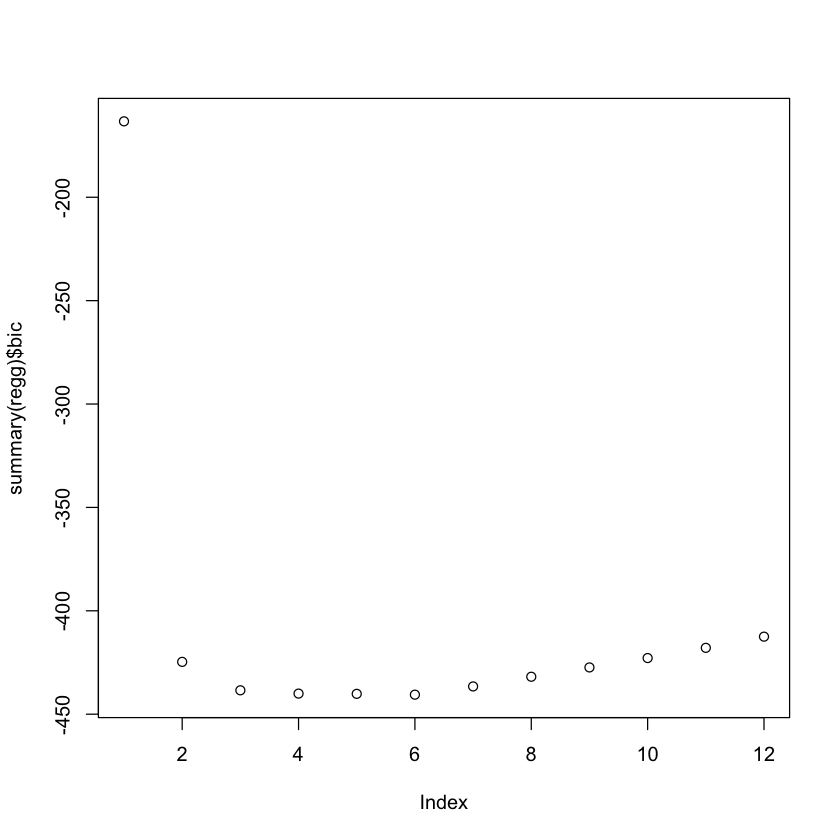

In [44]:
regg = regsubsets(Num_Wins ~ . - team - season, data = ROW_train, nvmax =12)
plot(summary(regg)$bic)
which(summary(regg)$bic == min(summary(regg)$bic))

From the BIC plot, the optimal model has 6 parameters, the same number of parameters in our model found with backwards elimination.  Let's use regsubsets again to determine these 6 parameters.

In [46]:
regg2 = regsubsets(Num_Wins ~ . - team - season, data = ROW_train, nvmax =12)
summary(regg2)

Subset selection object
Call: regsubsets.formula(Num_Wins ~ . - team - season, data = ROW_train, 
    nvmax = 12)
17 Variables  (and intercept)
                 Forced in Forced out
Avg_SOG_For          FALSE      FALSE
Avg_Shot_Att_For     FALSE      FALSE
Avg_Goals_For        FALSE      FALSE
Avg_Rbds_For         FALSE      FALSE
Avg_PIM_For          FALSE      FALSE
Avg_FO_Win           FALSE      FALSE
Avg_FO_Lost          FALSE      FALSE
Avg_Hits_For         FALSE      FALSE
Avg_Tkwy_For         FALSE      FALSE
Avg_Gvwy_For         FALSE      FALSE
Avg_SOG_Ag           FALSE      FALSE
Avg_Shot_Att_Ag      FALSE      FALSE
Avg_GA               FALSE      FALSE
Avg_Rbds_Ag          FALSE      FALSE
Avg_Hits_Ag          FALSE      FALSE
Avg_Tkwy_Ag          FALSE      FALSE
Avg_Gvwy_Ag          FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: exhaustive
          Avg_SOG_For Avg_Shot_Att_For Avg_Goals_For Avg_Rbds_For Avg_PIM_For
1  ( 1 )  " "         " "     

They are the exact same parameters we found with backwards elimination.

In [32]:
modregg = lm(Num_Wins ~ Avg_Goals_For + Avg_PIM_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
             Avg_Hits_Ag, data = ROW_train)


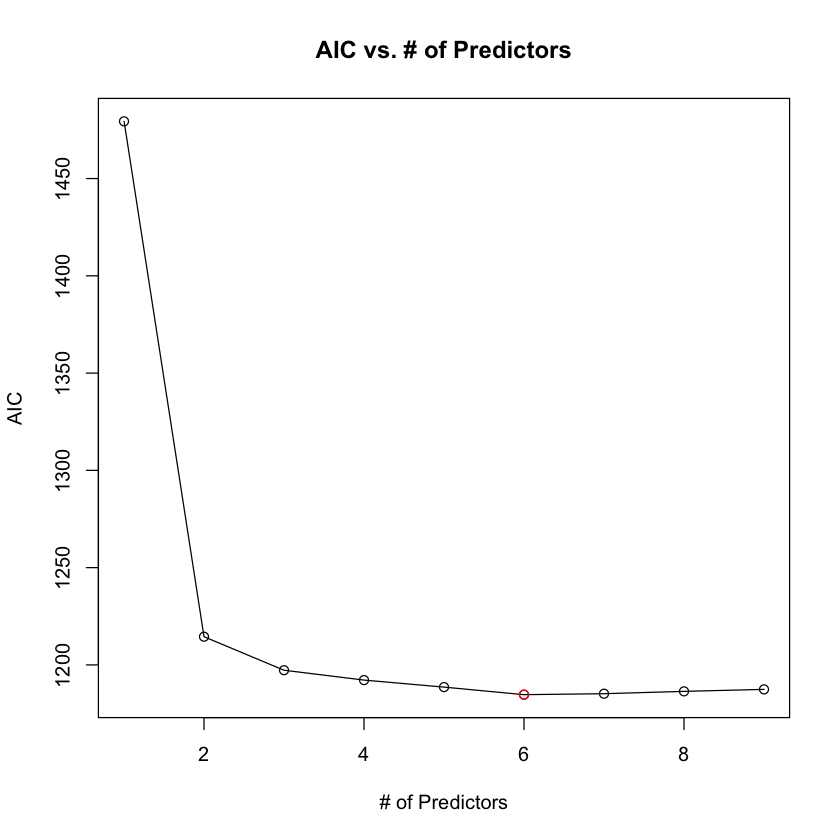

In [57]:
modr1 = lm(Num_Wins ~ Avg_Goals_For, data = ROW_train); modr2 = update(modr1, .~. + Avg_GA);
modr3 = update(modr2, .~. + Avg_PIM_For); modr4 = update(modr3, .~. + Avg_Rbds_Ag);
modr5 = update(modr4, .~. + Avg_SOG_Ag); modr6 = update(modr5, .~. +Avg_Hits_Ag);
modr7 = update(modr6, .~. + Avg_SOG_For); modr8 = update(modr7, .~. - Avg_SOG_For + Avg_FO_Win + Avg_Shot_Att_For)
modr9 = update(modr8, .~. - Avg_FO_Win + Avg_Gvwy_For + Avg_Gvwy_Ag)
aics = AIC(modr1, modr2, modr3, modr4, modr5, modr6, modr7, modr8, modr9)
plot(aics$df-2, aics$AIC, xlab = '# of Predictors', ylab = 'AIC', main = 'AIC vs. # of Predictors')
lines(aics$df-2, aics$AIC)
points(which(aics$AIC == min(aics$AIC)), min(aics$AIC), col = 'red')

### Create Model w/ Poisson Regression and Backwards Elimination and $\alpha_{crit}=0.20$

In [33]:
glmod = glm(Num_Wins ~ . - team - season, data = ROW_train, family = poisson)
summary(glmod)


Call:
glm(formula = Num_Wins ~ . - team - season, family = poisson, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71180  -0.29770  -0.00489   0.32930   1.05842  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.7832379  0.3797594   9.962  < 2e-16 ***
Avg_SOG_For       0.0011949  0.0159552   0.075    0.940    
Avg_Shot_Att_For -0.0020847  0.0080467  -0.259    0.796    
Avg_Goals_For     0.4477621  0.0431959  10.366  < 2e-16 ***
Avg_Rbds_For     -0.0022921  0.0434912  -0.053    0.958    
Avg_PIM_For      -0.0096048  0.0058225  -1.650    0.099 .  
Avg_FO_Win        0.0018347  0.0078741   0.233    0.816    
Avg_FO_Lost       0.0004513  0.0084827   0.053    0.958    
Avg_Hits_For     -0.0003008  0.0036997  -0.081    0.935    
Avg_Tkwy_For     -0.0028886  0.0137198  -0.211    0.833    
Avg_Gvwy_For     -0.0025519  0.0112443  -0.227    0.820    
Avg_SOG_Ag       -0.0120682  0.0121370  -0.994   

In [34]:
glmod2 = update(glmod, . ~ . -Avg_Shot_Att_Ag)
summary(glmod2)


Call:
glm(formula = Num_Wins ~ Avg_SOG_For + Avg_Shot_Att_For + Avg_Goals_For + 
    Avg_Rbds_For + Avg_PIM_For + Avg_FO_Win + Avg_FO_Lost + Avg_Hits_For + 
    Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, family = poisson, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71169  -0.29888  -0.00505   0.33001   1.06096  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.7817891  0.3707857  10.199  < 2e-16 ***
Avg_SOG_For       0.0013042  0.0147036   0.089    0.929    
Avg_Shot_Att_For -0.0021149  0.0078630  -0.269    0.788    
Avg_Goals_For     0.4476666  0.0428568  10.446  < 2e-16 ***
Avg_Rbds_For     -0.0024872  0.0420622  -0.059    0.953    
Avg_PIM_For      -0.0096040  0.0058223  -1.650    0.099 .  
Avg_FO_Win        0.0018381  0.0078717   0.233    0.815    
Avg_FO_Lost       0.0004077  0.0081152   0.050    0.960    
Avg_Hi

In [35]:
glmod3 = update(glmod2, . ~ . - Avg_FO_Lost)
summary(glmod3)


Call:
glm(formula = Num_Wins ~ Avg_SOG_For + Avg_Shot_Att_For + Avg_Goals_For + 
    Avg_Rbds_For + Avg_PIM_For + Avg_FO_Win + Avg_Hits_For + 
    Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, family = poisson, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.70946  -0.29816  -0.00443   0.33041   1.05966  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.791762   0.313181  12.107  < 2e-16 ***
Avg_SOG_For       0.001259   0.014677   0.086   0.9316    
Avg_Shot_Att_For -0.002091   0.007849  -0.266   0.7899    
Avg_Goals_For     0.447901   0.042598  10.515  < 2e-16 ***
Avg_Rbds_For     -0.002466   0.042057  -0.059   0.9532    
Avg_PIM_For      -0.009664   0.005697  -1.696   0.0898 .  
Avg_FO_Win        0.001807   0.007847   0.230   0.8179    
Avg_Hits_For     -0.000271   0.003634  -0.075   0.9406    
Avg_Tkwy_For     -0.002892   

In [36]:
glmod4 = update(glmod3, . ~ . - Avg_Rbds_For)
summary(glmod4)


Call:
glm(formula = Num_Wins ~ Avg_SOG_For + Avg_Shot_Att_For + Avg_Goals_For + 
    Avg_PIM_For + Avg_FO_Win + Avg_Hits_For + Avg_Tkwy_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Tkwy_Ag + Avg_Gvwy_Ag, family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.70987  -0.30248  -0.00514   0.33584   1.06224  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.7931288  0.3123044  12.146  < 2e-16 ***
Avg_SOG_For       0.0011157  0.0144716   0.077   0.9385    
Avg_Shot_Att_For -0.0021301  0.0078218  -0.272   0.7854    
Avg_Goals_For     0.4482249  0.0422383  10.612  < 2e-16 ***
Avg_PIM_For      -0.0096533  0.0056936  -1.695   0.0900 .  
Avg_FO_Win        0.0017534  0.0077947   0.225   0.8220    
Avg_Hits_For     -0.0002952  0.0036110  -0.082   0.9348    
Avg_Tkwy_For     -0.0030938  0.0132526  -0.233   0.8154    
Avg_Gvwy_For     -0.0024817  0.0111986  

In [37]:
glmod5 = update(glmod4, . ~ . - Avg_Tkwy_Ag)
summary(glmod5)


Call:
glm(formula = Num_Wins ~ Avg_SOG_For + Avg_Shot_Att_For + Avg_Goals_For + 
    Avg_PIM_For + Avg_FO_Win + Avg_Hits_For + Avg_Tkwy_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Gvwy_Ag, family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.70779  -0.30267  -0.00442   0.33227   1.06160  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.7940279  0.3119502  12.162   <2e-16 ***
Avg_SOG_For       0.0011156  0.0144719   0.077   0.9386    
Avg_Shot_Att_For -0.0021412  0.0078193  -0.274   0.7842    
Avg_Goals_For     0.4479345  0.0419675  10.673   <2e-16 ***
Avg_PIM_For      -0.0096779  0.0056793  -1.704   0.0884 .  
Avg_FO_Win        0.0017820  0.0077803   0.229   0.8188    
Avg_Hits_For     -0.0002877  0.0036091  -0.080   0.9365    
Avg_Tkwy_For     -0.0036550  0.0095316  -0.383   0.7014    
Avg_Gvwy_For     -0.0024982  0.0111944  -0.223   0.823

In [38]:
glmod6 = update(glmod5, . ~ . - Avg_SOG_For)
summary(glmod6)


Call:
glm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_Hits_For + Avg_Tkwy_For + Avg_Gvwy_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, 
    family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.70850  -0.30412   0.00074   0.33730   1.06265  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.7996639  0.3032559  12.530   <2e-16 ***
Avg_Shot_Att_For -0.0016258  0.0040530  -0.401   0.6883    
Avg_Goals_For     0.4490390  0.0394439  11.384   <2e-16 ***
Avg_PIM_For      -0.0097470  0.0056083  -1.738   0.0822 .  
Avg_FO_Win        0.0016686  0.0076397   0.218   0.8271    
Avg_Hits_For     -0.0002993  0.0036059  -0.083   0.9339    
Avg_Tkwy_For     -0.0036061  0.0095107  -0.379   0.7046    
Avg_Gvwy_For     -0.0025733  0.0111531  -0.231   0.8175    
Avg_SOG_Ag       -0.0118605  0.0073596  -1.612   0.1071    
Avg_GA  

In [39]:
glmod7 = update(glmod6, . ~ . - Avg_Hits_For)
summary(glmod7)


Call:
glm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + 
    Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, family = poisson, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71073  -0.30455  -0.00263   0.33721   1.06674  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.798256   0.302787  12.544   <2e-16 ***
Avg_Shot_Att_For -0.001626   0.004053  -0.401   0.6884    
Avg_Goals_For     0.449580   0.038899  11.558   <2e-16 ***
Avg_PIM_For      -0.009852   0.005463  -1.803   0.0713 .  
Avg_FO_Win        0.001660   0.007640   0.217   0.8280    
Avg_Tkwy_For     -0.003501   0.009425  -0.371   0.7103    
Avg_Gvwy_For     -0.002498   0.011116  -0.225   0.8222    
Avg_SOG_Ag       -0.011875   0.007358  -1.614   0.1065    
Avg_GA           -0.375593   0.045314  -8.289   <2e-16 ***
Avg_Rbds_Ag       0.067068   0.03

In [40]:
glmod8 = update(glmod7, . ~ . - Avg_FO_Win)
summary(glmod8)


Call:
glm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Gvwy_Ag, family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71317  -0.30236  -0.00316   0.34760   1.06859  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.822252   0.281916  13.558   <2e-16 ***
Avg_Shot_Att_For -0.001236   0.003635  -0.340   0.7338    
Avg_Goals_For     0.449584   0.038900  11.557   <2e-16 ***
Avg_PIM_For      -0.010022   0.005407  -1.853   0.0638 .  
Avg_Tkwy_For     -0.003696   0.009381  -0.394   0.6936    
Avg_Gvwy_For     -0.002725   0.011066  -0.246   0.8055    
Avg_SOG_Ag       -0.011616   0.007261  -1.600   0.1096    
Avg_GA           -0.375754   0.045308  -8.293   <2e-16 ***
Avg_Rbds_Ag       0.066730   0.039232   1.701   0.0890 .  
Avg_Hits_Ag      -0.003336   0.003961  -0.842   0.3

In [41]:
glmod9 = update(glmod8, . ~ . - Avg_Gvwy_For)
summary(glmod9)


Call:
glm(formula = Num_Wins ~ Avg_Shot_Att_For + Avg_Goals_For + Avg_PIM_For + 
    Avg_Tkwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Gvwy_Ag, family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71099  -0.29913  -0.00294   0.34807   1.05781  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.819487   0.281610  13.563   <2e-16 ***
Avg_Shot_Att_For -0.001159   0.003622  -0.320   0.7489    
Avg_Goals_For     0.449151   0.038868  11.556   <2e-16 ***
Avg_PIM_For      -0.009915   0.005390  -1.840   0.0658 .  
Avg_Tkwy_For     -0.004001   0.009300  -0.430   0.6670    
Avg_SOG_Ag       -0.011383   0.007197  -1.582   0.1138    
Avg_GA           -0.377107   0.044974  -8.385   <2e-16 ***
Avg_Rbds_Ag       0.064766   0.038412   1.686   0.0918 .  
Avg_Hits_Ag      -0.003301   0.003958  -0.834   0.4043    
Avg_Gvwy_Ag       0.003576   0.007343   0.487   0.6262    
---
Sig

In [42]:
glmod10 = update(glmod9, . ~ . - Avg_Shot_Att_For)
summary(glmod10)


Call:
glm(formula = Num_Wins ~ Avg_Goals_For + Avg_PIM_For + Avg_Tkwy_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, 
    family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71219  -0.30260  -0.00249   0.32918   1.09543  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    3.769099   0.233569  16.137   <2e-16 ***
Avg_Goals_For  0.444155   0.035596  12.478   <2e-16 ***
Avg_PIM_For   -0.009764   0.005369  -1.818   0.0690 .  
Avg_Tkwy_For  -0.004443   0.009195  -0.483   0.6290    
Avg_SOG_Ag    -0.010818   0.006977  -1.551   0.1210    
Avg_GA        -0.377223   0.044969  -8.389   <2e-16 ***
Avg_Rbds_Ag    0.063964   0.038326   1.669   0.0951 .  
Avg_Hits_Ag   -0.003713   0.003743  -0.992   0.3212    
Avg_Gvwy_Ag    0.002961   0.007089   0.418   0.6762    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken 

In [43]:
glmod11 = update(glmod10, . ~ . - Avg_Gvwy_Ag)
summary(glmod11)


Call:
glm(formula = Num_Wins ~ Avg_Goals_For + Avg_PIM_For + Avg_Tkwy_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag, family = poisson, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.72168  -0.30642  -0.00592   0.31423   1.11781  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    3.770843   0.233512  16.148   <2e-16 ***
Avg_Goals_For  0.446256   0.035227  12.668   <2e-16 ***
Avg_PIM_For   -0.010155   0.005287  -1.921   0.0548 .  
Avg_Tkwy_For  -0.003413   0.008856  -0.385   0.6999    
Avg_SOG_Ag    -0.010582   0.006954  -1.522   0.1281    
Avg_GA        -0.375618   0.044813  -8.382   <2e-16 ***
Avg_Rbds_Ag    0.063528   0.038310   1.658   0.0973 .  
Avg_Hits_Ag   -0.003543   0.003720  -0.952   0.3409    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 372.227  on 240  degrees of freedom
Resid

In [44]:
glmod12 = update(glmod11, . ~ . - Avg_Tkwy_For)
summary(glmod12)


Call:
glm(formula = Num_Wins ~ Avg_Goals_For + Avg_PIM_For + Avg_SOG_Ag + 
    Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag, family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.71547  -0.30702  -0.00078   0.32339   1.14531  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    3.754161   0.229435  16.363   <2e-16 ***
Avg_Goals_For  0.442489   0.033850  13.072   <2e-16 ***
Avg_PIM_For   -0.009744   0.005176  -1.882   0.0598 .  
Avg_SOG_Ag    -0.010301   0.006916  -1.489   0.1364    
Avg_GA        -0.379592   0.043614  -8.703   <2e-16 ***
Avg_Rbds_Ag    0.062918   0.038293   1.643   0.1004    
Avg_Hits_Ag   -0.003401   0.003701  -0.919   0.3581    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 372.227  on 240  degrees of freedom
Residual deviance:  58.172  on 234  degrees of freedom
AIC: 1379.3

Number of Fis

In [45]:
glmod13 = update(glmod12, . ~ . - Avg_Hits_Ag)
summary(glmod13)


Call:
glm(formula = Num_Wins ~ Avg_Goals_For + Avg_PIM_For + Avg_SOG_Ag + 
    Avg_GA + Avg_Rbds_Ag, family = poisson, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.68261  -0.34820  -0.00305   0.32570   1.14222  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    3.643032   0.194969  18.685   <2e-16 ***
Avg_Goals_For  0.440590   0.033795  13.037   <2e-16 ***
Avg_PIM_For   -0.009132   0.005136  -1.778   0.0754 .  
Avg_SOG_Ag    -0.009858   0.006899  -1.429   0.1530    
Avg_GA        -0.371232   0.042667  -8.701   <2e-16 ***
Avg_Rbds_Ag    0.061697   0.038277   1.612   0.1070    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 372.227  on 240  degrees of freedom
Residual deviance:  59.017  on 235  degrees of freedom
AIC: 1378.2

Number of Fisher Scoring iterations: 3


### Check Poisson Model on Testing Dataset and  MSE of Full and Reduced Model

In [46]:
preds_full_p = predict(glmod, ROW_test, type = 'response')
checks_full_p = cbind(preds_full_p, ROW_test$Num_Wins)
head(checks_full_p)
MSE_full_p = mean((preds_full_p - ROW_test$Num_Wins)^2)
MSE_full_p

,preds_full_p,
132,36.15894,41
109,39.40156,39
46,34.93326,35
124,36.30184,38
195,34.32176,35
258,39.85461,38


[1] 6.20471

In [47]:
preds_red_p = predict(glmod13, ROW_test, type = 'response')
checks_red_p = cbind(preds_red_p, ROW_test$Num_Wins)
head(checks_red_p)
MSE_red_p = mean((preds_red_p - ROW_test$Num_Wins)^2)
MSE_red_p

,preds_red_p,
132,36.01251,41
109,39.18568,39
46,35.57513,35
124,36.39736,38
195,35.39289,35
258,39.80399,38


[1] 6.635082

The MSE of the Poisson reduced model actually slightly increased in comparison to the Poisson full model, but is higher than that of the Linear Regression Model.

### Create Poisson Model w/ bestglm function

In [48]:
# deleting 4 to least significant predictors to run bestglm
# delete = c('team','season','Avg_Shot_Att_Ag', 'Avg_FO_Lost')
# ROW_test_bg = ROW_test[, -which(names(ROW_test) %in% delete)]
# ROW_train_bg = ROW_train[, -which(names(ROW_train) %in% delete)]

# best_pois_mod = bestglm(ROW_train_bg, IC = 'AIC', family = poisson)

Morgan-Tatar search since family is non-gaussian.


In [49]:
# best_pois_mod

AIC
BICq equivalent for q in (0.642119506632223, 0.867452680480205)
Best Model:
                 Estimate  Std. Error    z value      Pr(>|z|)
(Intercept)    3.49714446 0.144852214  24.142844 8.877532e-129
Avg_Goals_For  0.44599583 0.033528302  13.302070  2.251470e-40
Avg_PIM_For   -0.01043773 0.005040189  -2.070901  3.836806e-02
Avg_GA        -0.38130864 0.034421665 -11.077577  1.611756e-28

In [43]:
# bestglmod = glm(Num_Wins ~ Avg_Goals_For + Avg_GA + Avg_PIM_For, 
#                data = ROW_test, family = poisson)


In [44]:
# pred = predict(bestglmod, ROW_train, type = 'response')
# checks_best_glmod = cbind(pred, ROW_train$Num_Wins)
# MSE_best_glmod = mean((pred-ROW_train$Num_Wins)^2)
# MSE_best_glmod

[1] 10.39209

### Create Model w/ Binomial

In [51]:
bmod = glm(cbind(Num_Wins, 82-Num_Wins) ~ . -team - season, data = ROW_train, 
          family = binomial)
summary(bmod)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ . - team - season, 
    family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.78572  -0.38832   0.00454   0.37077   1.38387  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.1268648  0.5165733   0.246   0.8060    
Avg_SOG_For      -0.0002411  0.0219615  -0.011   0.9912    
Avg_Shot_Att_For -0.0044272  0.0110614  -0.400   0.6890    
Avg_Goals_For     0.8481697  0.0612329  13.852   <2e-16 ***
Avg_Rbds_For     -0.0098784  0.0600012  -0.165   0.8692    
Avg_PIM_For      -0.0191234  0.0078106  -2.448   0.0143 *  
Avg_FO_Win        0.0054478  0.0107191   0.508   0.6113    
Avg_FO_Lost      -0.0010531  0.0115658  -0.091   0.9275    
Avg_Hits_For      0.0003480  0.0050976   0.068   0.9456    
Avg_Tkwy_For     -0.0064886  0.0187661  -0.346   0.7295    
Avg_Gvwy_For     -0.0091653  0.0153639  -0.597   0.5508    
Avg_SOG_Ag       -0.020663

In [52]:
bmod2 = update(bmod, . ~ . - Avg_Shot_Att_Ag)
summary(bmod2)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_SOG_For + 
    Avg_Shot_Att_For + Avg_Goals_For + Avg_Rbds_For + Avg_PIM_For + 
    Avg_FO_Win + Avg_FO_Lost + Avg_Hits_For + Avg_Tkwy_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Tkwy_Ag + Avg_Gvwy_Ag, family = binomial, data = ROW_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7853  -0.3884   0.0048   0.3709   1.3835  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.1275288  0.5045619   0.253   0.8005    
Avg_SOG_For      -0.0002938  0.0201266  -0.015   0.9884    
Avg_Shot_Att_For -0.0044125  0.0107840  -0.409   0.6824    
Avg_Goals_For     0.8482221  0.0606053  13.996   <2e-16 ***
Avg_Rbds_For     -0.0097830  0.0578522  -0.169   0.8657    
Avg_PIM_For      -0.0191238  0.0078103  -2.449   0.0143 *  
Avg_FO_Win        0.0054450  0.0107088   0.508   0.6111    
Avg_FO_Lost      -0.0010336  0.0110990  -0.093   0.92

In [53]:
bmod3 = update(bmod2, . ~ . - Avg_SOG_For)
summary(bmod3)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_Rbds_For + Avg_PIM_For + Avg_FO_Win + 
    Avg_FO_Lost + Avg_Hits_For + Avg_Tkwy_For + Avg_Gvwy_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Tkwy_Ag + 
    Avg_Gvwy_Ag, family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.78415  -0.38847   0.00514   0.37159   1.38236  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.1257820  0.4901653   0.257   0.7975    
Avg_Shot_Att_For -0.0045432  0.0060034  -0.757   0.4492    
Avg_Goals_For     0.8479024  0.0565082  15.005   <2e-16 ***
Avg_Rbds_For     -0.0099204  0.0570820  -0.174   0.8620    
Avg_PIM_For      -0.0191053  0.0077072  -2.479   0.0132 *  
Avg_FO_Win        0.0054777  0.0104719   0.523   0.6009    
Avg_FO_Lost      -0.0010213  0.0110673  -0.092   0.9265    
Avg_Hits_For      0.0003526  0.0050864   0.069   0.9447  

In [54]:
bmod4 = update(bmod3, . ~ . - Avg_Hits_For)
summary(bmod4)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_Rbds_For + Avg_PIM_For + Avg_FO_Win + 
    Avg_FO_Lost + Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + 
    Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, 
    family = binomial, data = ROW_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7848  -0.3924   0.0069   0.3721   1.3835  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.1236527  0.4892065   0.253   0.8005    
Avg_Shot_Att_For -0.0045596  0.0059987  -0.760   0.4472    
Avg_Goals_For     0.8472213  0.0556459  15.225   <2e-16 ***
Avg_Rbds_For     -0.0095148  0.0567811  -0.168   0.8669    
Avg_PIM_For      -0.0189644  0.0074341  -2.551   0.0107 *  
Avg_FO_Win        0.0054965  0.0104683   0.525   0.5995    
Avg_FO_Lost      -0.0008779  0.0108723  -0.081   0.9356    
Avg_Tkwy_For     -0.0065964  0.0186741  -0.353   0.7239    
Avg_Gvwy_For     -0.00

In [55]:
bmod5 = update(bmod4, . ~ . - Avg_FO_Lost)
summary(bmod5)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_Rbds_For + Avg_PIM_For + Avg_FO_Win + 
    Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Tkwy_Ag + Avg_Gvwy_Ag, family = binomial, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.78690  -0.38857   0.00791   0.36801   1.39498  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.102566   0.413669   0.248   0.8042    
Avg_Shot_Att_For -0.004567   0.005998  -0.761   0.4464    
Avg_Goals_For     0.846854   0.055459  15.270   <2e-16 ***
Avg_Rbds_For     -0.009562   0.056779  -0.168   0.8663    
Avg_PIM_For      -0.018867   0.007335  -2.572   0.0101 *  
Avg_FO_Win        0.005558   0.010441   0.532   0.5945    
Avg_Tkwy_For     -0.006612   0.018673  -0.354   0.7233    
Avg_Gvwy_For     -0.009242   0.015256  -0.606   0.5447    
Avg_SOG_Ag       -0.020811   0.0104

In [56]:
bmod6 = update(bmod5, . ~ . - Avg_Tkwy_Ag)
summary(bmod6)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_Rbds_For + Avg_PIM_For + Avg_FO_Win + 
    Avg_Tkwy_For + Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Gvwy_Ag, family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.78552  -0.38931   0.01441   0.37282   1.39444  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.100284   0.413051   0.243   0.8082    
Avg_Shot_Att_For -0.004475   0.005928  -0.755   0.4502    
Avg_Goals_For     0.847284   0.055292  15.324   <2e-16 ***
Avg_Rbds_For     -0.010893   0.055197  -0.197   0.8436    
Avg_PIM_For      -0.018835   0.007328  -2.570   0.0102 *  
Avg_FO_Win        0.005516   0.010433   0.529   0.5970    
Avg_Tkwy_For     -0.005248   0.012738  -0.412   0.6804    
Avg_Gvwy_For     -0.009187   0.015246  -0.603   0.5468    
Avg_SOG_Ag       -0.020901   0.010450  -2.000   0.0455

In [57]:
bmod7 = update(bmod6, . ~ . - Avg_Rbds_For)
summary(bmod7)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_PIM_For + Avg_FO_Win + Avg_Tkwy_For + 
    Avg_Gvwy_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + 
    Avg_Gvwy_Ag, family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.78851  -0.39990   0.00212   0.36967   1.40438  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.102106   0.412939   0.247   0.8047    
Avg_Shot_Att_For -0.004921   0.005482  -0.898   0.3694    
Avg_Goals_For     0.848490   0.054955  15.440   <2e-16 ***
Avg_PIM_For      -0.018773   0.007322  -2.564   0.0103 *  
Avg_FO_Win        0.005302   0.010376   0.511   0.6093    
Avg_Tkwy_For     -0.005584   0.012622  -0.442   0.6582    
Avg_Gvwy_For     -0.008915   0.015183  -0.587   0.5571    
Avg_SOG_Ag       -0.020332   0.010044  -2.024   0.0429 *  
Avg_GA           -0.680760   0.061786 -11.018   <2e-16 ***
Avg_Rbds_A

In [58]:
bmod8 = update(bmod7, . ~ . - Avg_Tkwy_For)
summary(bmod8)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_PIM_For + Avg_FO_Win + Avg_Gvwy_For + 
    Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, 
    family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.76181  -0.41406   0.03144   0.37927   1.40950  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.088380   0.411759   0.215   0.8300    
Avg_Shot_Att_For -0.005368   0.005388  -0.996   0.3191    
Avg_Goals_For     0.845389   0.054501  15.511   <2e-16 ***
Avg_PIM_For      -0.018435   0.007281  -2.532   0.0113 *  
Avg_FO_Win        0.005717   0.010333   0.553   0.5801    
Avg_Gvwy_For     -0.009736   0.015070  -0.646   0.5182    
Avg_SOG_Ag       -0.020116   0.010032  -2.005   0.0449 *  
Avg_GA           -0.685452   0.060876 -11.260   <2e-16 ***
Avg_Rbds_Ag       0.125099   0.053138   2.354   0.0186 *  
Avg_Hits_Ag      -0.00676

In [59]:
bmod9 = update(bmod8, . ~ . - Avg_FO_Win)
summary(bmod9)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_PIM_For + Avg_Gvwy_For + Avg_SOG_Ag + 
    Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag + Avg_Gvwy_Ag, family = binomial, 
    data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.78869  -0.40021   0.00294   0.40213   1.38383  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.172952   0.382334   0.452  0.65101    
Avg_Shot_Att_For -0.004100   0.004875  -0.841  0.40037    
Avg_Goals_For     0.844755   0.054490  15.503  < 2e-16 ***
Avg_PIM_For      -0.019001   0.007209  -2.636  0.00839 ** 
Avg_Gvwy_For     -0.010515   0.015004  -0.701  0.48341    
Avg_SOG_Ag       -0.019284   0.009919  -1.944  0.05188 .  
Avg_GA           -0.686097   0.060864 -11.273  < 2e-16 ***
Avg_Rbds_Ag       0.124539   0.053128   2.344  0.01907 *  
Avg_Hits_Ag      -0.006619   0.005312  -1.246  0.21270    
Avg_Gvwy_Ag       0.015591   0.017906 

In [60]:
bmod10 = update(bmod9, . ~ . - Avg_Gvwy_For)
summary(bmod10)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_PIM_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag + Avg_Gvwy_Ag, family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.81775  -0.40258   0.01165   0.42090   1.35726  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.161936   0.381934   0.424  0.67157    
Avg_Shot_Att_For -0.003833   0.004860  -0.789  0.43035    
Avg_Goals_For     0.841221   0.054251  15.506  < 2e-16 ***
Avg_PIM_For      -0.018470   0.007169  -2.576  0.00998 ** 
Avg_SOG_Ag       -0.018467   0.009849  -1.875  0.06080 .  
Avg_GA           -0.691638   0.060351 -11.460  < 2e-16 ***
Avg_Rbds_Ag       0.117433   0.052157   2.252  0.02435 *  
Avg_Hits_Ag      -0.006382   0.005300  -1.204  0.22858    
Avg_Gvwy_Ag       0.005100   0.009826   0.519  0.60375    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0

In [61]:
bmod11 = update(bmod10, . ~ . - Avg_Gvwy_Ag)
summary(bmod11)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Shot_Att_For + 
    Avg_Goals_For + Avg_PIM_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + 
    Avg_Hits_Ag, family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.79443  -0.41086  -0.00063   0.41680   1.35413  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.135663   0.378545   0.358  0.72006    
Avg_Shot_Att_For -0.003068   0.004631  -0.662  0.50772    
Avg_Goals_For     0.842918   0.054143  15.568  < 2e-16 ***
Avg_PIM_For      -0.019073   0.007074  -2.696  0.00701 ** 
Avg_SOG_Ag       -0.017838   0.009774  -1.825  0.06799 .  
Avg_GA           -0.687335   0.059781 -11.498  < 2e-16 ***
Avg_Rbds_Ag       0.116452   0.052121   2.234  0.02547 *  
Avg_Hits_Ag      -0.006415   0.005299  -1.211  0.22606    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    N

In [62]:
bmod12 = update(bmod11, . ~ . - Avg_Shot_Att_For)
summary(bmod12)


Call:
glm(formula = cbind(Num_Wins, 82 - Num_Wins) ~ Avg_Goals_For + 
    Avg_PIM_For + Avg_SOG_Ag + Avg_GA + Avg_Rbds_Ag + Avg_Hits_Ag, 
    family = binomial, data = ROW_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.79714  -0.38102  -0.00421   0.41195   1.43061  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.006369   0.311993  -0.020  0.98371    
Avg_Goals_For  0.825862   0.047617  17.344  < 2e-16 ***
Avg_PIM_For   -0.018238   0.006960  -2.620  0.00879 ** 
Avg_SOG_Ag    -0.016271   0.009484  -1.716  0.08624 .  
Avg_GA        -0.690366   0.059602 -11.583  < 2e-16 ***
Avg_Rbds_Ag    0.113610   0.051939   2.187  0.02872 *  
Avg_Hits_Ag   -0.007516   0.005032  -1.494  0.13526    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 662.050  on 240  degrees of freedom
Residual deviance:  91.953  on 234  degrees of freed

In [72]:
pred_b = predict(bmod12, ROW_test, type = 'response')
checks_b = cbind(pred_b*82, ROW_test$Num_Wins)
head(checks_b)
MSE_pred_b = mean((checks_b[,1] - checks_b[,2])^2)
MSE_pred_b

132,37.36248,41
109,39.52715,39
46,36.45842,35
124,37.31950,38
195,34.88337,35
258,40.55935,38


[1] 5.535168